In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import timedelta
import sys
sys.path.append('../../lib/')
from analysis import *
import pickle as pkl

In [2]:
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, \
    Input, BatchNormalization, multiply, concatenate, Flatten, Activation, dot
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

import pydot as pyd
from tensorflow.keras.utils import plot_model, model_to_dot
import tensorflow
tensorflow.keras.utils.pydot = pyd

Read Data

In [3]:
data = pkl.load(open('../../Data/data.pkl', 'rb'))

X_input_train = data['X_input_train']
X_output_train = data['X_output_train']
X_input_test = data['X_input_test']
X_output_test = data['X_output_test']

x_trend_param = data['x_trend_param']
x_train_max = data['x_train_max']

Model

In [4]:
input_train = Input(shape=(X_input_train.shape[1], X_input_train.shape[2]-1))
output_train = Input(shape=(X_output_train.shape[1], X_output_train.shape[2]-1))
n_hidden = 100
print(input_train)
print(output_train)

KerasTensor(type_spec=TensorSpec(shape=(None, 200, 1), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 20, 1), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")


In [5]:
encoder_last_h1, encoder_last_h2, encoder_last_c = LSTM(
    n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, 
    return_sequences=False, return_state=True)(input_train)
print(encoder_last_h1)
print(encoder_last_h2)
print(encoder_last_c)

KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='lstm/strided_slice_3:0', description="created by layer 'lstm'")
KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='lstm/while:4', description="created by layer 'lstm'")
KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='lstm/while:5', description="created by layer 'lstm'")


In [6]:
encoder_last_h1 = BatchNormalization(momentum=0.6)(encoder_last_h1) 
print(encoder_last_h1)

KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='batch_normalization/batchnorm/add_1:0', description="created by layer 'batch_normalization'")


In [7]:
encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c) 
print(encoder_last_c)

KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='batch_normalization_1/batchnorm/add_1:0', description="created by layer 'batch_normalization_1'")


In [8]:
decoder = RepeatVector(output_train.shape[1])(encoder_last_h1)
print(decoder)

KerasTensor(type_spec=TensorSpec(shape=(None, 20, 100), dtype=tf.float32, name=None), name='repeat_vector/Tile:0', description="created by layer 'repeat_vector'")


In [9]:
decoder = LSTM(n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2,
               return_state=False, return_sequences=True)(
    decoder, initial_state=[encoder_last_h1, encoder_last_c])
print(decoder)

KerasTensor(type_spec=TensorSpec(shape=(None, 20, 100), dtype=tf.float32, name=None), name='lstm_1/transpose_1:0', description="created by layer 'lstm_1'")


In [10]:
out = TimeDistributed(Dense(output_train.shape[2]))(decoder)
print(out)

KerasTensor(type_spec=TensorSpec(shape=(None, 20, 1), dtype=tf.float32, name=None), name='time_distributed/Reshape_1:0', description="created by layer 'time_distributed'")


In [11]:
model = Model(inputs=input_train, outputs=out)
opt = Adam(lr=0.01, clipnorm=1)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 1)]     0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 100),        40800       ['input_1[0][0]']                
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 batch_normalization (BatchNorm  (None, 100)         400         ['lstm[0][0]']                   
 alization)                                                                                   

C:\Users\manue\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


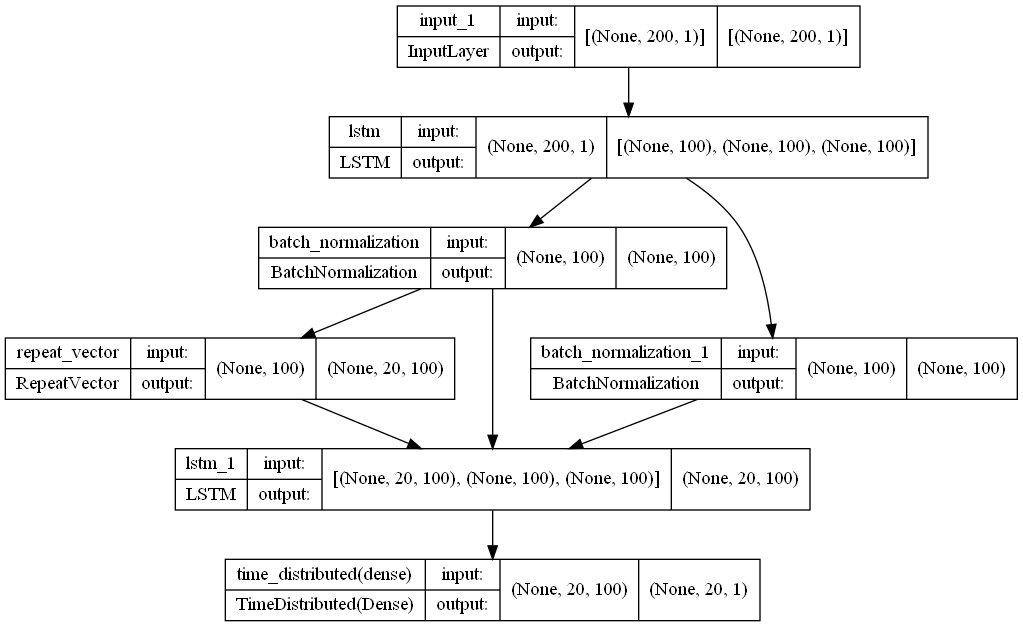

In [12]:
plot_model(model, to_file='../../Images/model_plot.png', show_shapes=True, show_layer_names=True)

In [13]:
epc = 100
es = EarlyStopping(monitor='val_loss', mode='min', patience=50)
history = model.fit(X_input_train[:, :, :1], X_output_train[:, :, :1], validation_split=0.2, 
                    epochs=epc, verbose=1, callbacks=[es], 
                    batch_size=300)
train_mae = history.history['mae']
valid_mae = history.history['val_mae']
 
model.save('model_forecasting_seq2seq.h5')

Epoch 1/100
2/2 [==============================] - 7s 1s/step - loss: 67.1378 - mae: 3.4964 - val_loss: 0.1177 - val_mae: 0.3003
Epoch 2/100
2/2 [==============================] - 2s 766ms/step - loss: 2.5906 - mae: 1.0258 - val_loss: 0.2301 - val_mae: 0.4306
Epoch 3/100
2/2 [==============================] - 2s 762ms/step - loss: 0.9561 - mae: 0.6636 - val_loss: 0.2787 - val_mae: 0.4572
Epoch 4/100
2/2 [==============================] - 2s 751ms/step - loss: 0.6036 - mae: 0.5827 - val_loss: 0.2514 - val_mae: 0.4383
Epoch 5/100
2/2 [==============================] - 2s 787ms/step - loss: 0.2790 - mae: 0.3775 - val_loss: 0.1874 - val_mae: 0.3779
Epoch 6/100
2/2 [==============================] - 2s 792ms/step - loss: 0.1446 - mae: 0.2988 - val_loss: 0.1790 - val_mae: 0.3396
Epoch 7/100
2/2 [==============================] - 2s 767ms/step - loss: 0.1450 - mae: 0.2872 - val_loss: 0.1702 - val_mae: 0.3614
Epoch 8/100
2/2 [==============================] - 2s 847ms/step - loss: 0.1144 - mae

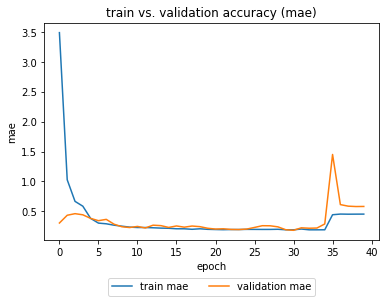

In [14]:
plt.plot(train_mae, label='train mae'), 
plt.plot(valid_mae, label='validation mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.title('train vs. validation accuracy (mae)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

Predict

In [18]:
def LSTM_model_prediction(model, X_input_train, X_input_test, x_train_max,
                          X_output_train, X_output_test):
    
    train_pred_detrend = model.predict(X_input_train[:, :, :1])*x_train_max[:2]
    test_pred_detrend = model.predict(X_input_test[:, :, :1])*x_train_max[:2]

    train_true_detrend = X_output_train[:, :, :1]*x_train_max[:2]
    test_true_detrend = X_output_test[:, :, :1]*x_train_max[:2]
    
    # combine with the index
    train_pred_detrend = np.concatenate([train_pred_detrend,
                                         np.expand_dims(X_output_train[:, :, 1],
                                                        axis=2)], axis=2)
    test_pred_detrend = np.concatenate([test_pred_detrend,
                                        np.expand_dims(X_output_test[:, :, 1],
                                                       axis=2)], axis=2)

    train_true_detrend = np.concatenate([train_true_detrend,
                                         np.expand_dims(X_output_train[:, :, 1],
                                                        axis=2)], axis=2)
    test_true_detrend = np.concatenate([test_true_detrend,
                                        np.expand_dims(X_output_test[:, :, 1],
                                                       axis=2)], axis=2)
    # recover trend
    data_final = dict()

    for dt, lb in zip([train_pred_detrend, train_true_detrend, test_pred_detrend, test_true_detrend], 
                    ['train_pred', 'train_true', 'test_pred', 'test_true']):
        dt_x = dt[:, :, 0] + dt[:, :, 1] * x_trend_param[0] + x_trend_param[1]
        data_final[lb] = np.expand_dims(dt_x, axis=2)    
    
    return data_final


data_final = LSTM_model_prediction(model, X_input_train, X_input_test, x_train_max,
                                   X_output_train, X_output_test)

In [16]:
for k in ['train_pred', 'train_true', 'test_pred', 'test_true']:
    print('maximum: {}'.format(k))
    print(data_final[k].max())

maximum: train_pred
nan
maximum: train_true
25285.37453592877
maximum: test_pred
nan
maximum: test_true
24948.27873213366


C:\Users\manue\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\axes\_axes.py:6731: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
C:\Users\manue\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\axes\_axes.py:6732: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

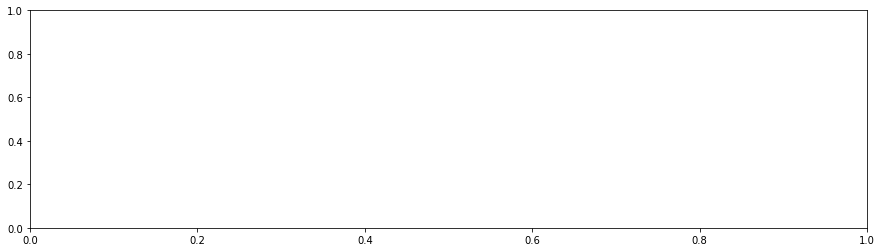

In [17]:
for lb in ['train', 'test']:
    plt.figure(figsize=(15, 4))
    plt.hist(data_final[lb+'_pred'].flatten(), bins=100, color='orange', alpha=0.5, label=lb+' pred')
    plt.hist(data_final[lb+'_true'].flatten(), bins=100, color='green', alpha=0.5, label=lb+' true')
    plt.legend()
    plt.title('value distribution: '+lb)
    plt.show()

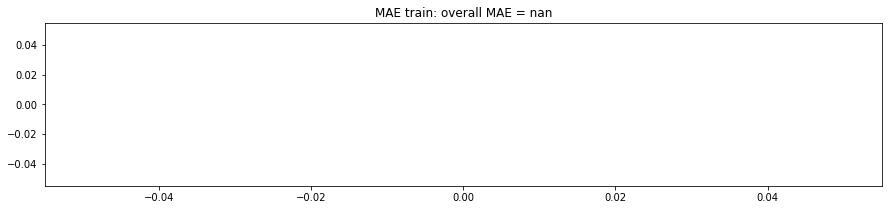

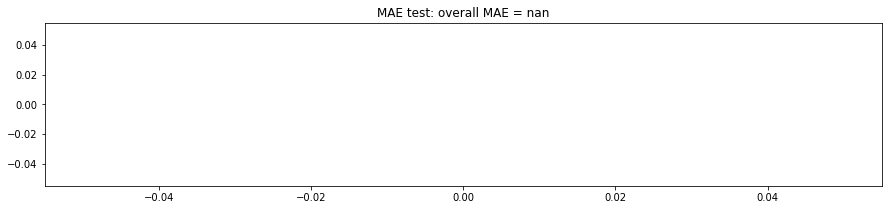

In [ ]:
for lb in ['train', 'test']:
    MAE_overall = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean()
    MAE_ = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean(axis=(1, 2))
    plt.figure(figsize=(15, 3))
    plt.plot(MAE_)
    plt.title('MAE '+lb+': overall MAE = '+str(MAE_overall))
    plt.show() 

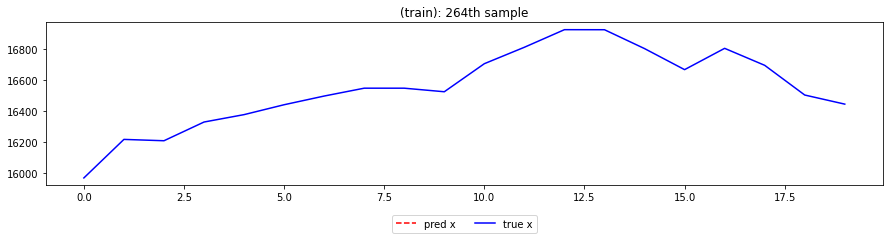

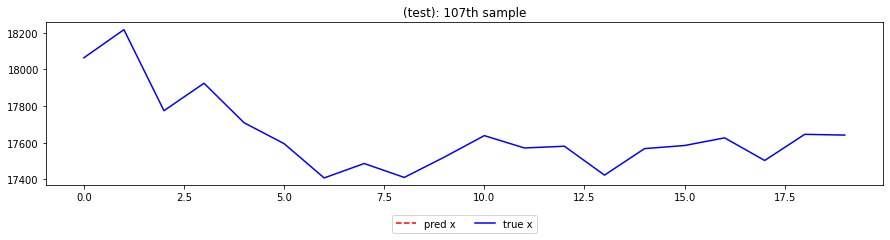

In [20]:
import random

for lb in ['train', 'test']:
    ith_sample = random.choice(range(data_final[lb+'_pred'].shape[0]))

    plt.figure(figsize=(15,3))
    plt.plot(data_final[lb+'_pred'][ith_sample, :, 0], linestyle='--', color='r', label='pred x')
    plt.plot(data_final[lb+'_true'][ith_sample, :, 0], linestyle='-', color='b', label='true x')
    plt.title('({}): {}th sample'.format(lb, ith_sample))
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
    plt.show()

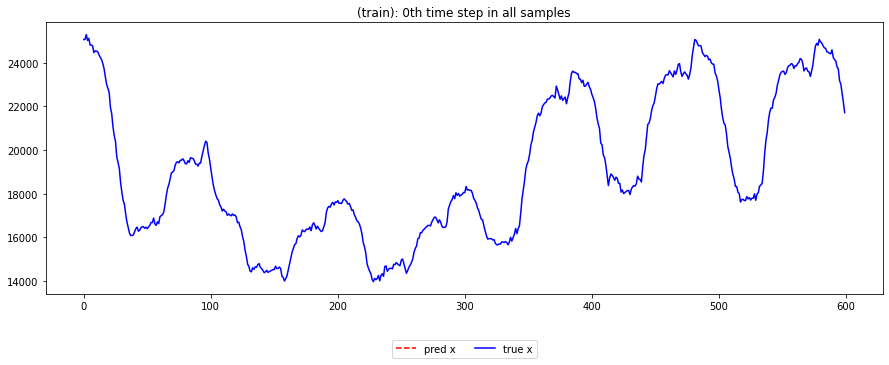

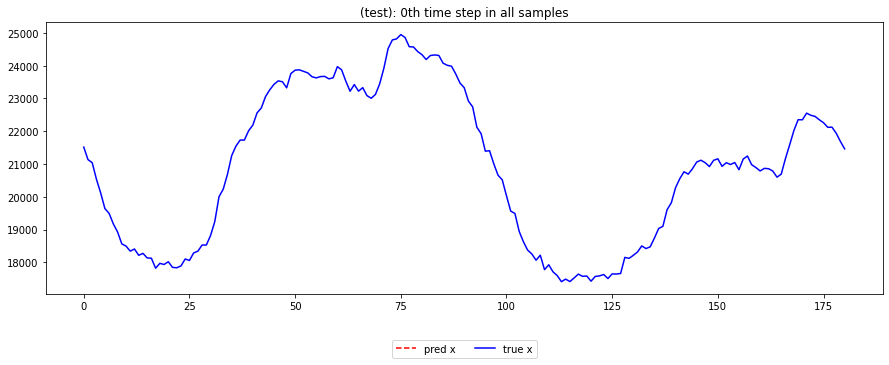

In [22]:
timestep = random.choice(range(data_final[lb+'_pred'].shape[1]))
for lb in ['train', 'test']:   
    plt.figure(figsize=(15, 5))
    plt.plot(data_final[lb+'_pred'][:, timestep, 0], linestyle='--', color='r', label='pred x')
    plt.plot(data_final[lb+'_true'][:, timestep, 0], linestyle='-', color='b', label='true x')
    plt.title('({}): {}th time step in all samples'.format(lb, timestep))
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
    plt.show()

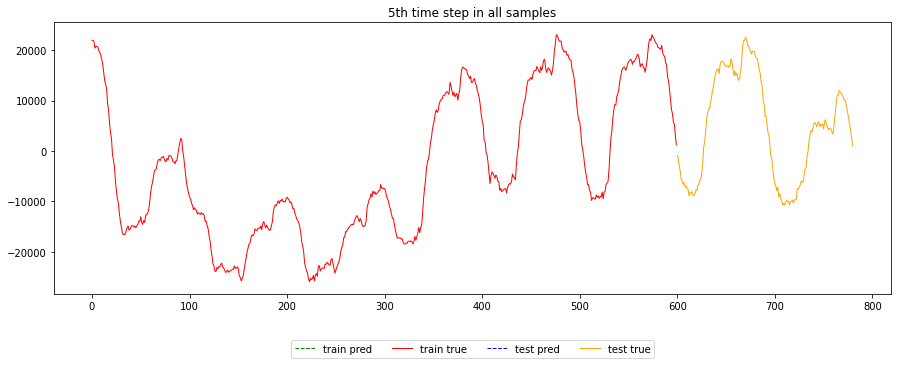

In [ ]:
plt.figure(figsize=(15, 5))
train_start_t = 0
test_start_t = data_final['train_pred'].shape[0]


labels = ['train', 'test']
variables = [train_start_t, test_start_t]
colors = [['green', 'red'], ['blue', 'orange']]

for lb, tm, clrs in zip(labels, variables, colors):
    n = data_final[f'{lb}_pred'].shape[0]
    plt.plot(range(tm, tm + n), 
             data_final[f'{lb}_pred'][:, timestep, 0], 
             linestyle='--', linewidth=1, color=clrs[0], label=f'{lb} pred')
    plt.plot(range(tm, tm + n), 
             data_final[f'{lb}_true'][:, timestep, 0], 
             linestyle='-', linewidth=1, color=clrs[1], label=f'{lb} true')
    
plt.title(f'{timestep}th time step in all samples')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
           fancybox=True, shadow=False, ncol=8)
plt.show()

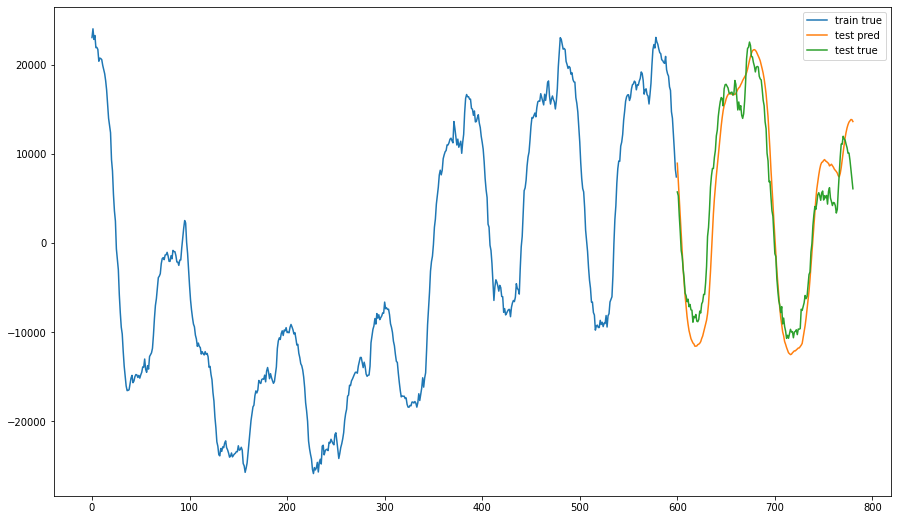

In [ ]:
plt.figure(figsize=(15, 9))
i = 1
lentgh_train = len(data_final['train_pred'])
lentgh_test = len(data_final['test_pred'])

t = range(lentgh_train, lentgh_train+lentgh_test)
plt.plot(data_final['train_true'][:, i ,0], label='train true')
plt.plot(t, data_final['test_pred'][:, i ,0], label='test pred')
plt.plot(t, data_final['test_true'][:, i ,0], label='test true')
plt.legend()